# Correlation and Relationships

In den vorherigen Notebooks haben wir unseren OECD-Wohlstandsdatensatz zunächst **aufbereitet und bereinigt** (Notebook 01) und anschließend **deskriptiv analysiert** (Notebook 02). Dort haben wir insbesondere unsere Zielvariable *"Feeling safe at night"* definiert, ihre Verteilung untersucht und erste Unterschiede zwischen Ländern beobachtet.

In diesem dritten Notebook geht es nun um **Zusammenhänge** zwischen Indikatoren:  
Wir wollen prüfen, ob das wahrgenommene Sicherheitsgefühl mit anderen Wohlstandsindikatoren (z.B. Lebenszufriedenheit, sozialer Unterstützung oder Kriminalität) zusammenhängt – und zwar nicht nur „gefühlt“, sondern mit den Methoden aus den Vorlesungen zur Korrelation.

Aktuell liegen die Werte im Rohdatensatz **untereinander** (eine Zeile pro Measure und Land). Um Korrelationen berechnen zu können, müssen die relevanten Kennzahlen für jedes Land als **Spalten nebeneinander** vorliegen. Im ersten Schritt transformieren wir den Datensatz daher in ein Wide-Format (Pivot), bevor wir visuell und statistisch Zusammenhänge untersuchen.


## 1. Setup & Daten Laden

In [2]:
#!pip install pingouin
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import pingouin as pg

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

In Notebook 01 haben wir zwei zentrale Datensätze, `oecd_snapshot_latest.csv` und `oecd_full_time_series.csv`, eingeführt:

Für eine **Korrelationsanalyse auf Länderebene** ist aus Sicht der Vorlesung die **Unabhängigkeit der Beobachtungen** entscheidend. Deswegen verwenden wir hier bewusst die `snapshot`-Datei (`oecd_snapshot_latest.csv`).

**Warum nicht die Time Series?**

Wenn wir die komplette Zeitreihe nutzen würden, hätten wir für jedes Land mehrere, stark abhängige Beobachtungen (z.B. Österreich 2010, 2011, 2012 …). Das Sicherheitsgefühl eines Landes im Jahr $t$ hängt aber inhaltlich eng mit den Werten in den Folgejahren zusammen. Die Annahme unabhängiger Beobachtungen wäre damit verletzt, und wir würden die Stichprobengröße künstlich „aufblasen“. Das führt typischerweise zu **zu kleinen p-Werten** und damit zu überoptimistischen Ergebnissen.

Da wir in diesem Notebook eine **Querschnittsanalyse über Länder** durchführen wollen (Unsere Frage: *„Haben Länder mit bestimmten Eigenschaften tendenziell ein höheres oder niedrigeres Sicherheitsgefühl?“*), ist es konsequent, nur **eine Beobachtung pro Land** zu verwenden.


In [4]:
base_dir = Path.cwd()
data_file = 'oecd_snapshot_latest.csv'
candidates = [
    base_dir / 'data' / data_file,
    base_dir.parent / 'data' / data_file,
]
data_path = next((p for p in candidates if p.exists()), None)
if data_path is None:
    raise FileNotFoundError(f"Datei nicht gefunden. Versucht wurden: {candidates}")
print(f"Lade Daten von: {data_path}")

try:
    df = pd.read_csv(data_path)
    print("Daten erfolgreich geladen.")

    df = df.loc[:, ~df.columns.duplicated()]
        
except FileNotFoundError:
    print(f"FEHLER: Datei nicht gefunden unter {data_path}")


Lade Daten von: /Users/Flurina/Library/CloudStorage/OneDrive-Persönlich/Documents/Uni_St.Gallen/BCS/3.Semester/Statistik_für_Data_Science/Projekt/Statistik_Projekt_OECDWellBeing/data/oecd_snapshot_latest.csv
Daten erfolgreich geladen.


## 2. Daten Transformation

Im Rohformat steht jede Zeile für eine Kombination aus Land (*reference_area*), Indikator (*measure*) und Wert (*value*). Für eine Korrelationsanalyse benötigen wir jedoch eine Struktur, in der **jede Zeile ein Land** ist und **jede Spalte ein Indikator**.

Dafür verwenden wir einen `pivot`:

- Index: `reference_area` (Länder)
- Spalten: `measure` (Indikatoren)
- Werte: `value` (Kennzahlen, hier gemittelt, falls mehrere Werte vorkommen)

Nach dem Pivot sehen wir, dass wir einen Datensatz mit `n = 47` Ländern erhalten. Damit haben wir eine saubere Basis, um Korrelationen zwischen den einzelnen Indikatoren zu berechnen.

In [5]:
target_sex = 'Total' if 'Total' in df['sex'].unique() else '_T'
target_age = 'Total' if 'Total' in df['age'].unique() else '_T'

In [6]:
mask = (df['sex'] == target_sex) & (df['age'] == target_age)
df_filtered = df[mask].copy()

In [7]:
df_pivot = df_filtered.pivot_table(
    index='reference_area', 
    columns='measure', 
    values='value',
    aggfunc='mean' 
)

print(f"\nDatensatz transformiert. Anzahl Länder: {len(df_pivot)}")


Datensatz transformiert. Anzahl Länder: 47


### 3. VARIABLEN SELEKTION

Wir behalten unsere **Zielvariable** `Feeling safe at night`

Aus dem `pivot`-Datensatz stehen uns viele weitere Wohlstandsindikatoren zur Verfügung (Einkommen, Gesundheit, Umwelt, subjektives Wohlbefinden, etc.). Wir wählen für dieses Notebook gezielt diejenigen Variablen aus, die inhaltlich plausibel mit dem Sicherheitsgefühl zusammenhängen könnten und in den Vorlesungen auch als Beispiele für Korrelation und Regressionsanalysen dienen könnten:

- **Sozialer Kontext / Unterstützung**: z.B. `Social support` / `Lack of social support`, `Satisfaction with personal relationships`
- **Subjektives Wohlbefinden**: `Life satisfaction`, `Negative affect balance`
- **Kriminalität / Risiko**: `Homicides`, `Road deaths`
- **Ökonomischer Hintergrund**: `Median net wealth`, `Households and NPISHs net adjusted disposable income per capita`, `Difficulty making ends meet`

Wir beschränken uns bewusst auf eine **überschaubare Auswahl** an Variablen, statt „blind“ alle Spalten zu korrelieren. So bleiben die Analysen interpretierbar, und jede Korrelation lässt sich inhaltlich begründen. Gleichzeitig behalten wir mit der späteren Korrelationsmatrix einen Überblick, ob vielleicht unerwartete Zusammenhänge auftauchen.


In [8]:
# Zielvariable aus Notebook 2
target_var = "Feeling safe at night"

# Verfügbare Indikatoren prüfen
print(df_pivot.columns.tolist())

['Access to green space', 'Adult literacy skills', 'Adult numeracy skills', 'Adults with low literacy skills', 'Adults with low numeracy skills', 'Average annual gross earnings', 'Deaths from suicide, alcohol, drugs', 'Difficulty making ends meet', 'Employment rate', 'Equivalised liquid financial assets below three months of the annual national relative income poverty line', 'Exposed to air pollution', 'Exposure to extreme temperature', 'Feeling lonely', 'Feeling safe at night', 'Feelings of physical pain', 'Full-time employees earning less than two-thirds of gross median earnings', 'Gender gap in working hours', 'Gender wage gap', 'Having a say in government', 'Homicides', 'Household disposable income below the relative income poverty line', 'Households and NPISHs net adjusted disposable income per capita', 'Households living in overcrowded conditions', 'Households with internet access at home', 'Housing affordability', 'Housing cost overburden', 'Inability to keep home adequately war

In [9]:
potential_drivers = [
    "Social support",    
    "Homicides",         
    "Life satisfaction", 
    "Median net wealth",
    "Difficulty making ends meet"
]

In [10]:
# intersection, um Tippfehler abzufangen
cols_to_use = [target_var] + potential_drivers
# nur die Spalten nehmen, die auch wirklich da sind
valid_cols = df_pivot.columns.intersection(cols_to_use)
df_corr = df_pivot[valid_cols].copy()

# alle Daten -> Zahlenformat, alles was kein Text ist -> NaN
for col in df_corr.columns:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

# Wir löschen Länder, die in diesen Spalten NaNs haben (Listwise Deletion) -> Korrelation braucht vollständige Paare
df_corr = df_corr.dropna()

print(f"\nAnalyse-Tabelle erstellt mit {df_corr.shape[0]} Ländern.")
df_corr.head()


Analyse-Tabelle erstellt mit 26 Ländern.


measure,Difficulty making ends meet,Feeling safe at night,Homicides,Life satisfaction,Median net wealth,Social support
reference_area,,,,,,
Austria,13.1,82.546060,0.4,7.575,189148.0,89.024267
Belgium,17.2,68.829203,0.7,7.550,343656.0,91.298786
Canada,20.4,73.163202,0.8,7.400,336829.0,90.730572
Croatia,19.8,77.833333,0.7,7.125,151212.0,90.838590
Czechia,14.2,76.741255,0.5,7.425,193239.0,93.843487


## 4. Visuelle Prüfung

Bevor wir Korrelationen als reine Zahlen berechnen, schauen wir zunächst **grafisch** auf die Zusammenhänge. Dafür erstellen wir Scatterplots mit Regressionslinie.

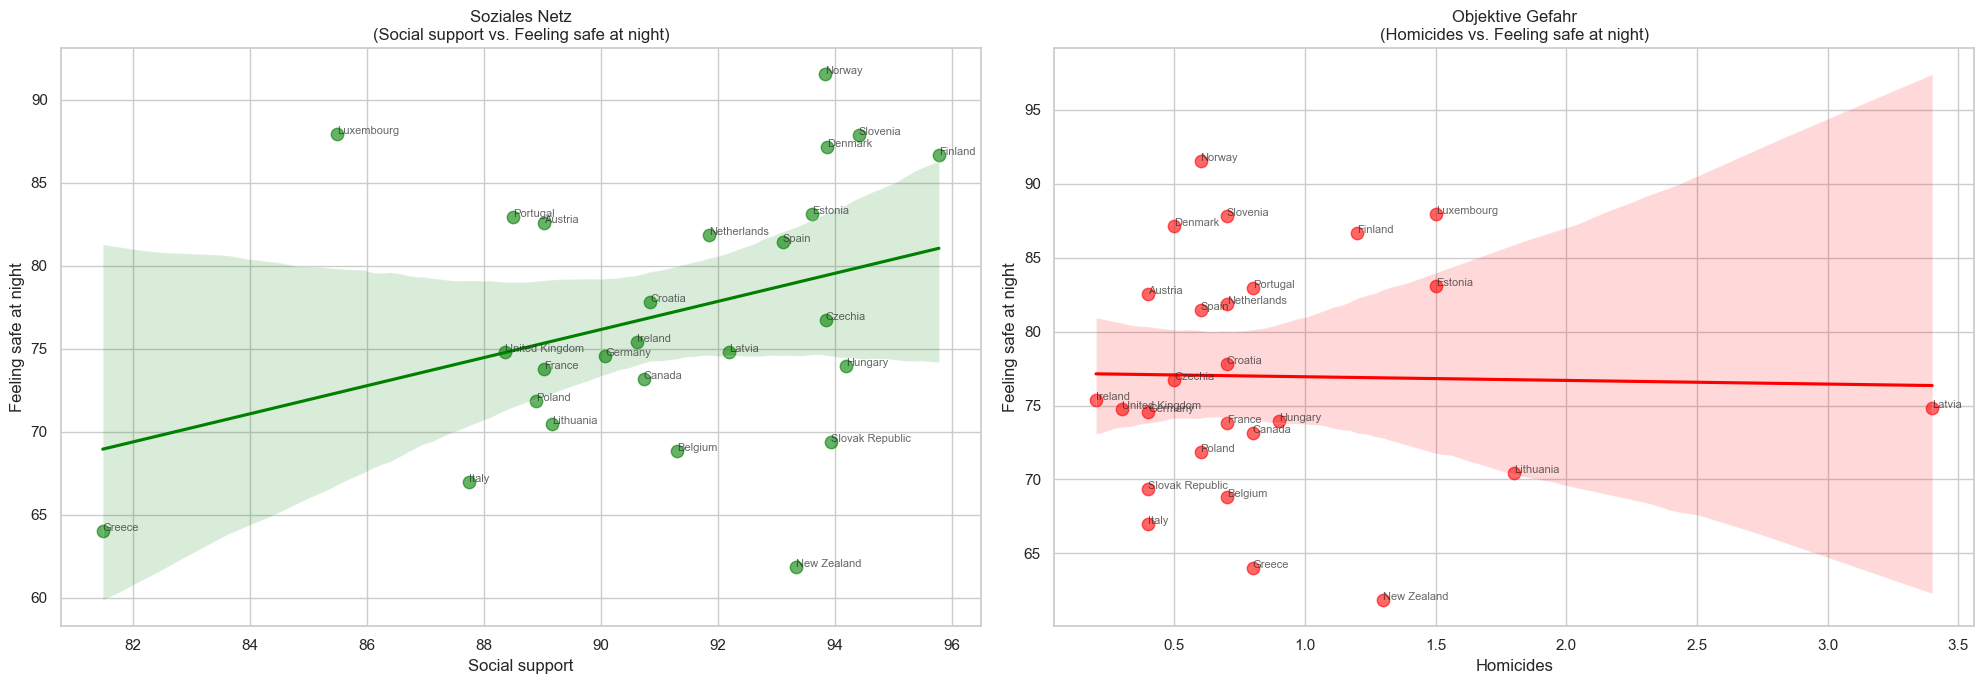

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot 1: Social Support
sns.regplot(data=df_corr, x="Social support", y=target_var, ax=ax[0], 
            color="green", scatter_kws={'s': 80, 'alpha': 0.6})
ax[0].set_title(f"Soziales Netz\n(Social support vs. {target_var})")

# Plot 2: Homicides
sns.regplot(data=df_corr, x="Homicides", y=target_var, ax=ax[1], 
            color="red", scatter_kws={'s': 80, 'alpha': 0.6})
ax[1].set_title(f"Objektive Gefahr\n(Homicides vs. {target_var})")

for i in range(df_corr.shape[0]):
    ax[0].text(df_corr["Social support"].iloc[i], df_corr[target_var].iloc[i], 
               df_corr.index[i], fontsize=8, alpha=0.7)
    ax[1].text(df_corr["Homicides"].iloc[i], df_corr[target_var].iloc[i], 
               df_corr.index[i], fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

## Analyse der beiden Plots: Soziales Netz vs. Sicherheitsgefühl & Mordrate vs. Sicherheitsgefühl

Im linken Plot („Social support vs. Feeling safe at night“) sehen wir ein recht klares Muster. Länder mit höherer sozialer Unterstützung liegen tendenziell weiter oben auf der y-Achse, also beim Sicherheitsgefühl. Die Regressionslinie verläuft steigend und fasst genau diesen Trend zusammen: je stärker das soziale Netz, desto höher fällt im Mittel der Wert „Feeling safe at night“ aus. Besonders Länder wie Norwegen, Dänemark, Slowenien oder Finnland kombinieren sehr hohe Social-support-Werte mit einem sehr hohen Sicherheitsgefühl. Griechenland liegt hingegen deutlich unter dem Trend – trotz eines mittleren bis hohen Social-support-Werts ist das Sicherheitsgefühl vergleichsweise niedrig. Solche Punkte machen sichtbar, dass Social support ist ein wichtiger Prädiktor ist, aber nicht die komplette Streuung erklärt; es bleiben weitere Einflussfaktoren, die im Modell noch nicht berücksichtigt sind.

Der rechte Plot („Homicides vs. Feeling safe at night“) zeigt ein ganz anderes Bild. Die Regressionslinie ist nahezu horizontal und auch innerhalb des Bereichs sehr niedriger Mordraten – also dort, wo sich die meisten Länder befinden – streuen die Sicherheitswerte stark: Einige Länder mit sehr niedriger Mordrate berichten hohe Sicherheitswerte, andere eher mittlere. Selbst das Land mit der höchsten Mordrate in unserem Sample (Lettland) liegt nicht extrem weit vom allgemeinen Niveau entfernt. Gleichzeitig wird die Konfidenzbandbreite der Regressionslinie nach rechts hin sehr breit, was darauf hinweist, dass wir für hohe Homicide-Werte nur sehr wenige Beobachtungen haben und die Schätzung dort entsprechend unsicher ist.

Für Social support sehen wir einen plausiblen, wenn auch nicht perfekt linearen, positiven Zusammenhang, den die Regressionslinie gut einfängt. Bei den Homicides lässt sich dagegen kein klarer (und schon gar kein monotone) Trend erkennen, und die lineare Regression liefert deshalb praktisch eine flache Linie. Insgesamt ist die visuelle Evidenz für Hypothese 1 („ein stärkeres soziales Netz geht mit höherem Sicherheitsgefühl einher“) deutlich überzeugender als für Hypothese 2 („höhere Mordrate senkt das Sicherheitsgefühl“). Die formalen Rangkorrelationstests im nächsten Schritt überprüfen diese Eindrücke dann statistisch.


## 5. Korrelation

In der deskriptiven Analyse haben wir festgestellt, dass unsere Zielvariable *"Feeling safe at night"* **nicht normalverteilt** ist (siehe QQ-Plot) und eine **Linksschiefe** sowie **Ausreißer** aufweist (siehe Histogramm & Boxplot).

Aufgrund dieser Verletzung der Annahmen ist der klassische **Pearson-Korrelationskoeffizient** ($r$) hier methodisch inkorrekt, da er Normalverteilung und Linearität voraussetzt und anfällig für Ausreißer ist. -> Wir nutzen nichtpararametrische Verfahren (**Rangkorrelationen**)

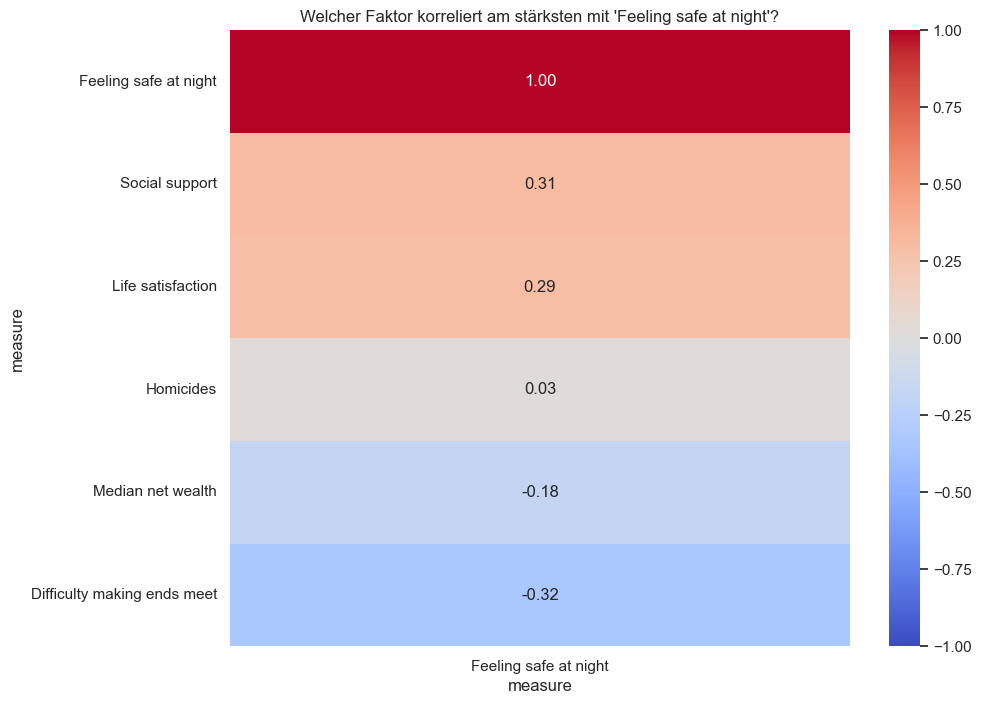

In [12]:
corr_matrix = df_corr.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[[target_var]].sort_values(by=target_var, ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title(f"Welcher Faktor korreliert am stärksten mit '{target_var}'?")
plt.show()

In der Heatmap sehen wir:

- Mehrere Indikatoren, die **positiv** mit dem Sicherheitsgefühl korrelieren, z.B. Variablen im Bereich subjektives Wohlbefinden und soziale Unterstützung (etwa *Life satisfaction*, *Social support* oder *Satisfaction with personal relationships*).
- Andere Variablen weisen eher **negative** Zusammenhänge auf, etwa solche, die Belastungen oder Risiken messen (z.B. *Feeling lonely*, *Homicides* oder Indikatoren finanzieller Unsicherheit).

Die Korrelationen sind überwiegend im **kleinen bis mittleren Bereich**, was typisch ist für aggregierte Länderdaten: viele Faktoren wirken gleichzeitig, und einzelne Indikatoren erklären nur einen Teil der Variation im Sicherheitsgefühl.

Die Heatmap dient uns hier vor allem als **Orientierung**, um zu entscheiden:

- Welche Variablen sind gute Kandidaten für einen **formalen Hypothesentest** (NB 03)?  
- Welche Variablen bieten sich später als **Prädiktoren in Regressionsmodellen** an (NB 05)?


Wir verwenden zwei unterschiedliche Rangkorrelationsmaße:

1. **Spearman's Rho ($\rho$)**  
   Spearman misst, ob ein Zusammenhang **monoton** ist, d.h. ob Länder mit höherem Wert in Variable A tendenziell einen höheren (oder niedrigeren) Wert in Variable B haben, unabhängig vom exakten funktionalen Verlauf. Dazu werden die Werte in Ränge umgewandelt. Ausreißer wie einzelne Länder mit extrem hoher oder niedriger Mordrate beeinflussen dann nur ihren Rang, nicht mehr den absoluten Abstand.

2. **Kendall's Tau ($\tau$)**  
   Kendall basiert auf der Zahl **konkordanter** vs. **diskordanter** Paare. Intuitiv betrachtet prüft Kendall, wie oft zwei Länder in beiden Variablen in der gleichen Reihenfolge sortiert sind.  
   Dieses Maß ist besonders hilfreich, wenn die Stichprobe – wie hier mit ca. zwei Dutzend Ländern – eher klein ist und es viele ähnliche Werte gibt (Ties).

Wenn beide Maße in die gleiche Richtung zeigen und ähnliche Signifikanzniveaus liefern, ist das ein starkes Indiz dafür, dass der gefundene Zusammenhang **robust** ist und nicht von der Wahl des konkreten Rangkorrelationsmaßes abhängt.

In [13]:
corr_spearman, p_spearman = stats.spearmanr(df_corr["Social support"], df_corr["Homicides"])
corr_kendall, p_kendall = stats.kendalltau(df_corr["Social support"], df_corr["Homicides"])

print(f"--- Vergleich der Rangkorrelationen für '{v1}' vs. '{v2}' ---")
print(f"Spearman rho: {corr_spearman:.4f} (p={p_spearman:.4f})")
print(f"Kendall tau:  {corr_kendall:.4f} (p={p_kendall:.4f})")

NameError: name 'v1' is not defined

Für den Zusammenhang zwischen *Social support* und *Homicides* liegen die beiden Rangkorrelationsmaße sehr nahe bei null:

- Spearman: ρ ≈ 0,11 bei p ≈ 0,60  
- Kendall: τ ≈ 0,05 bei p ≈ 0,71

Beide Koeffizienten sind klein und statistisch nicht signifikant. Wir finden in den Rangordnungen der Länder kein systematisches Muster, nach dem Länder mit höherer Mordrate gleichzeitig konsistent geringere oder höhere Werte bei der sozialen Unterstützung hätten.

Wichtig ist, dass Spearman und Kendall in dieselbe Richtung weisen (leicht positiv, aber nahe null) und beide einen sehr hohen p-Wert liefern. Dadurch wird unsere Schlussfolgerung robust gegenüber der Wahl des Rangmaßes: Unabhängig davon, ob wir Konkordanzwahrscheinlichkeiten (Kendall) oder Rangdifferenzen (Spearman) betrachten, gibt es in diesem Datensatz keinen belastbaren monotonen Zusammenhang zwischen Social support und Homicides.

Inhaltlich stützt das die Idee, dass soziale Unterstützung und objektive Gewalt nicht einfach zwei Seiten derselben Medaille sind. Ein Land kann also gleichzeitig ein hohes Maß an sozialem Rückhalt haben und dennoch eine erhöhte Mordrate aufweisen und umgekehrt.


## 6. Hypothesentest

Auf Basis der Korrelationsmatrix wählen wir zwei inhaltlich zentrale Kandidaten für einen formalen Test aus:

- *Social support* – als positive, soziale Ressource.
- *Homicides* – als direkte Kriminalitätskennzahl.

Wir formulieren für jede Variable einen **zweiseitigen Hypothesentest** auf Basis der Spearman-Korrelation:

- $H_0$: Es gibt **keinen monotonen Zusammenhang** zwischen der Variable und *Feeling safe at night* ($\rho = 0$).
- $H_1$: Es gibt einen **monotonen Zusammenhang** ($\rho \neq 0$).

Der Code kapselt diesen Ablauf (Hypothesen, Teststatistik, p-Wert, Entscheidung bei $\alpha = 0{,}05$) in einer Funktion, sodass wir die Logik transparent dokumentieren und wiederverwenden können.

In [ ]:
def test_correlation(var_name):
    """Führt einen Spearman-Test gegen die Zielvariable durch und gibt das Ergebnis aus."""
    
    # 1. Hypothesen aufstellen
    print(f"\n--- Test: {target_var} vs. {var_name} ---")
    print("H0: Es gibt keinen monotonen Zusammenhang (rho = 0).")
    print("H1: Es gibt einen monotonen Zusammenhang (rho != 0).")
    
    # 2. Test durchführen
    corr, p_val = stats.spearmanr(df_corr[target_var], df_corr[var_name])
    
    # 3. Ergebnisse
    print(f"Spearman-Korrelation (rho): {corr:.4f}")
    print(f"p-Wert: {p_val:.6f}")
    
    # 4. Entscheidung
    alpha = 0.05
    if p_val < alpha:
        print("ENTCHEIDUNG: p < 0.05 -> H0 verwerfen. Der Zusammenhang ist signifikant.")
    else:
        print("ENTCHEIDUNG: p >= 0.05 -> H0 beibehalten. Kein signifikanter Zusammenhang nachweisbar.")

# Wir testen unsere beiden Haupt-Kandidaten
test_correlation("Social support")
test_correlation("Homicides")


--- Test: Feeling safe at night vs. Social support ---
H0: Es gibt keinen monotonen Zusammenhang (rho = 0).
H1: Es gibt einen monotonen Zusammenhang (rho != 0).
Spearman-Korrelation (rho): 0.3060
p-Wert: 0.128458
ENTCHEIDUNG: p >= 0.05 -> H0 beibehalten. Kein signifikanter Zusammenhang nachweisbar.

--- Test: Feeling safe at night vs. Homicides ---
H0: Es gibt keinen monotonen Zusammenhang (rho = 0).
H1: Es gibt einen monotonen Zusammenhang (rho != 0).
Spearman-Korrelation (rho): 0.0293
p-Wert: 0.887165
ENTCHEIDUNG: p >= 0.05 -> H0 beibehalten. Kein signifikanter Zusammenhang nachweisbar.


### Hypothese 1: Soziales Netz (Social support)

Für den Zusammenhang zwischen *Social support* und *Feeling safe at night* ergibt sich:

- Spearman-Korrelation: $\rho = 0{,}3060$
- p-Wert: $p = 0{,}1285$

Bei einem Signifikanzniveau von $\alpha = 0{,}05$ liegt der p-Wert **über** $\alpha$. Wir **verwerfen $H_1$ nicht**, sondern **behalten die Nullhypothese bei**:

> Im OECD-Ländersample lässt sich kein statistisch signifikanter monotoner Zusammenhang zwischen sozialer Unterstützung und Sicherheitsgefühl nachweisen.

Inhaltlich ist der positive Wert von $\rho$ aber durchaus interessant: Länder mit mehr Social support *tendieren* zu höherer Sicherheit, nur reicht die Stichprobe mit 26 Ländern nicht aus, um diesen Trend statistisch abzusichern. Kendall’s $\tau$ ist ebenfalls positiv, aber ebenfalls nicht signifikant – damit ist das Ergebnis robust gegenüber der Wahl des Rangmaßes.

### Hypothese 2: Objektive Gefahr (Homicides)

Für *Homicides* als Maß objektiver Gewaltbelastung und *Feeling safe at night* erhalten wir:

- Spearman-Korrelation: $\rho = 0{,}0293$
- p-Wert: $p = 0{,}8872$

Der Korrelationskoeffizient liegt praktisch bei null, der p-Wert ist deutlich größer als $0{,}05$. Auch hier **behalten wir $H_0$ bei**:

> Auf Basis der vorliegenden Daten gibt es keinen Hinweis auf einen monotonen Zusammenhang zwischen Mordrate und subjektivem Sicherheitsgefühl auf Länderebene.

Kendall’s $\tau$ bestätigt dieses Bild: Der Koeffizient ist ebenfalls sehr klein und nicht signifikant. Damit steht fest, dass unsere geringe Korrelation weder ein Artefakt der Methode noch der Verteilung ist, sondern in diesen Daten schlicht kein stabiler Rangzusammenhang existiert.

### Zwischenfazit

Formell können wir damit beide Hypothesen **statistisch nicht bestätigen**. Hypothese 1 bekommt zumindest eine inhaltlich nachvollziehbare Tendenz (positive, aber nicht signifikante Rangkorrelation), Hypothese 2 wird dagegen klar widerlegt: Die Mordrate erklärt im OECD-Vergleich kaum, wie sicher sich Menschen nachts fühlen – zumindest nicht als einfacher monotone Zusammenhang.

!! Das bedeutet nicht, dass es „keinen Zusammenhang“ im Alltag gibt, sondern nur, dass wir mit dieser Stichprobe von OECD-Ländern und dieser Operationalisierung **keinen statistisch signifikanten monotonen Zusammenhang** nachweisen können. In Notebook 04 werden wir ähnliche Fragen mit **Gruppenvergleichen** prüfen, und in Notebook 05 betrachten wir dieselben Variablen noch einmal im Rahmen von **Regressionsmodellen**, die mehrere Faktoren gleichzeitig berücksichtigen.


## 7. DRITTVARIABLEN-CHECK

Korrelationen zwischen zwei Variablen können durch eine **dritte Variable** verzerrt oder sogar künstlich erzeugt werden (Confounding). In unserem Kontext ist eine naheliegende Drittvariable der **ökonomische Wohlstand eines Landes**, den wir über `Median net wealth` approximieren.

Um zu prüfen, ob der Zusammenhang zwischen *Social support* und *Feeling safe at night* möglicherweise durch den Reichtum eines Landes getrieben wird, gehen wir zweistufig vor:

1. **Stratifizierung nach Reichtum**  
   Wir teilen die Länder anhand des Medians des `Median net wealth` in zwei Gruppen ein: „ärmer“ und „reicher“. Innerhalb dieser Gruppen berechnen wir erneut die Spearman-Korrelation zwischen *Social support* und *Feeling safe at night*.  
   Wenn der Zusammenhang in beiden Reichtumsgruppen **ähnlich** bleibt, spricht das gegen ein starkes Confounding durch Reichtum. Wenn er sich dagegen deutlich verändert oder sogar umkehrt, wäre das ein Hinweis auf ein Drittvariablenproblem.

2. **Partielle Korrelation** (siehe nächster Abschnitt)  
   Zusätzlich berechnen wir eine partielle Korrelation, bei der der Einfluss von `Median net wealth` explizit „herausgerechnet“ wird.



Drittvariable kontrollieren: Median Wealth Split bei 186496.0


<Figure size 1000x600 with 0 Axes>

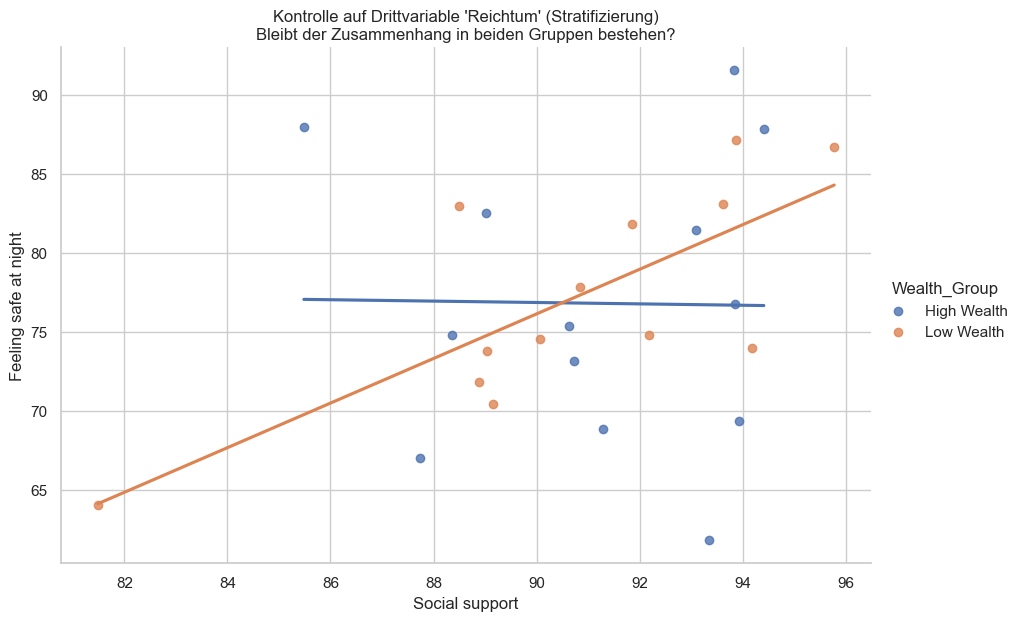

In [ ]:
wealth_median = df_corr["Median net wealth"].median()
df_corr["Wealth_Group"] = np.where(df_corr["Median net wealth"] > wealth_median, "High Wealth", "Low Wealth")

print(f"\nDrittvariable kontrollieren: Median Wealth Split bei {wealth_median}")

plt.figure(figsize=(10, 6))
sns.lmplot(data=df_corr, x="Social support", y=target_var, hue="Wealth_Group", 
           height=6, aspect=1.5, ci=None)

plt.title("Kontrolle auf Drittvariable 'Reichtum' (Stratifizierung)\nBleibt der Zusammenhang in beiden Gruppen bestehen?")
plt.show()

Der Stratifikations-Plot trennt die Länder in zwei Gruppen: „High Wealth“ und „Low Wealth“, basierend auf dem Median von *Median net wealth*. Für jede Gruppe wird eine separate Regressionslinie zwischen *Social support* und *Feeling safe at night* geschätzt.

In der **Low-Wealth-Gruppe** steigt die Linie deutlich an. Länder mit geringerer Vermögensbasis berichten also umso mehr Sicherheit, je stärker ihr soziales Netz ist. Hier scheint Social support tatsächlich als eine Art „Schutzfaktor“ zu wirken, der ökonomische Unsicherheit teilweise puffert: Wer sich auf andere verlassen kann, fühlt sich trotz begrenzter finanzieller Ressourcen sicherer.

In der **High-Wealth-Gruppe** ist die Linie dagegen nahezu flach. Reiche Länder erreichen beim Sicherheitsgefühl generell ein relativ hohes Niveau und zusätzliche Variationen im Social support schlagen sich kaum noch in der wahrgenommenen Sicherheit nieder. Man könnte es so zusammenfassen: Ab einem bestimmten materiellen Wohlstand ist das Grundniveau an Sicherheit offensichtlich so hoch, dass Social support nicht mehr der entscheidende limitierende Faktor ist.

Diese Muster sprechen dafür, dass Reichtum den Zusammenhang zwischen Social support und Sicherheitsgefühl moderiert: In ärmeren Ländern ist Social support stark wirksam, in reicheren Ländern ist der Effekt deutlich schwächer. Damit sehen wir zwar ein klassisches Drittvariablen-Phänomen, allerdings nicht im Sinne eines „Scheinkorrelationseffekts“, sondern eher als Hinweis auf unterschiedliche Wirkmechanismen in verschiedenen Kontexten.

## 8. PARTIELLE KORRELATION

Um den Einfluss von Reichtum genauer zu kontrollieren, verwenden wir eine **partielle Korrelation**. Die Idee ist:

> Wie stark hängen *Social support* und *Feeling safe at night* zusammen, wenn wir Länder vergleichen, die hinsichtlich `Median net wealth` gleich „gestellt“ sind?

In [ ]:
try:
    pcorr_df = df_corr.pcorr()

    stats_pcorr = pg.partial_corr(data=df_corr, x='Social support', y=target_var, 
                                 covar='Median net wealth', method='spearman')
    
    print("\n--- Partielle Korrelation (Kontrolle auf Reichtum) ---")
    print(stats_pcorr)
    
except ImportError:
    print("Pingouin nicht installiert. Führe '!pip install pingouin' aus für detaillierte Partial-Corr.")
    corrs = df_corr.groupby("Wealth_Group")[["Social support", target_var]].corr(method="spearman").iloc[0::2, -1]
    print("\n--- Korrelation in den Subgruppen (Stratifizierung) ---")
    print(corrs)


--- Partielle Korrelation (Kontrolle auf Reichtum) ---
           n         r         CI95%     p-val
spearman  26  0.271128  [-0.14, 0.6]  0.189873


Die partielle Korrelation kontrolliert *Median net wealth* explizit heraus. Unser Ergebnis lautet:

- n = 26 Länder  
- partielle Spearman-Korrelation $r \approx 0,27$
- 95 %-Konfidenzintervall grob von −0,14 bis 0,60  
- p-Wert $\approx 0,19$

Damit bleibt der Zusammenhang zwischen Social support und „Feeling safe at night“ auch nach Kontrolle des Reichtums *positiv*, wird aber statistisch nicht signifikant. Das breite Konfidenzintervall zeigt, dass die wahre Effektstärke in der Grundgesamtheit durchaus moderat positiv, aber im Extremfall auch leicht negativ sein könnte – unsere Stichprobe ist hierfür einfach zu klein.

Im Lichte der Vorlesung bedeutet das: Reichtum erklärt einen Teil der Unterschiede im Sicherheitsgefühl, nimmt Social support aber nicht vollständig „die Wirkung“. Der positive Trend bleibt sichtbar, ist aber zu unsicher, um ihn auf Basis dieser Daten verallgemeinern zu können. Die Kombination aus Stratifizierungs-Plot und partieller Korrelation legt nahe, dass Social support insbesondere in ärmeren Ländern ein relevanter Faktor für subjektive Sicherheit ist, während Reichtum in reicheren Ländern einen Großteil der Varianz bereits „abdeckt“.

Für die weiteren Notebooks ist das wichtig:  
In Notebook 04 können wir diese Muster mit Gruppenvergleichen (z. B. Low vs. High Support oder Low vs. High Wealth) weiter untersuchen. In Notebook 05 berücksichtigen wir Social support, Homicides und ökonomische Variablen gemeinsam in Regressionsmodellen, um genau zu prüfen, welche Faktoren das Sicherheitsgefühl *gleichzeitig* erklären.

Unsere Ergebnisse:

- eine **partielle Rangkorrelation** $r \approx 0{,}27$,
- ein Konfidenzintervall, das auch negative Werte einschließt,
- einen p-Wert von etwa $0{,}19$.

Interpretation:

- Der partielle Zusammenhang ist **positiv**, aber mit $\alpha = 0{,}05$ **nicht signifikant**.  
- Die Kontrolle für Reichtum verändert das Bild nicht dramatisch: es gibt Hinweise auf einen positiven Zusammenhang zwischen sozialer Unterstützung und Sicherheitsgefühl, aber aufgrund der kleinen Stichprobengröße und der Streuung können wir keinen klaren statistischen Nachweis erbringen.

Inhaltlich passt dieses Ergebnis gut zu den Beobachtungen der vorherigen Schritte: soziale Unterstützung scheint in vielen Ländern mit einem höheren Sicherheitsgefühl einherzugehen, aber die OECD-Länderebene ist zu grob und die Stichprobe zu klein, um einen klaren, robusten Effekt zu „beweisen“.